# EE 25614: Neuroscience of Learning, Memory, & Cognition
## Fall 2018
## PyTorch Tutorial Assignment
### Deadline: November 2, 2018

### Name: 
### Student ID:


In this assignment, you are tasked with implementing and training a simple recurrent neural network model using PyTorch. You will use this network to solve two tasks.



These are the steps you should take to complete this assignment:
1. Implement VanillaRNN class.
2. Train the network with the datasets you have generated. Visualize how loss changes through epochs.
4. Retrain the data using different sets of parameters. Report and visualize how changing each parameter changes loss. These parameters include:
    - Learning rate
    - Hidden layer size
    - Batch size
    - Number of Epochs
5. Report the parameters of your best network. Run the network on test data and visualize some examples of denoised signals the network makes.
6. Visualize activity of specific neurons through time as they process data in the parity task. Set hidden layer size to a small number for better visuals.

After completing the assignment, upload this notebook in a zip file with your student ID as its name on the CW website.

You should write all of the codes by yourself. Copying codes that are available on the internet or your classmates have written is prohibited.

If you have any questions about this assignment, please ask them on Piazza.

# Part 0: Generating datasets for two tasks.
You should write code that generates training and test datasets for each of the tasks below.


## Task 1: Predicting parity bit of a bit vector

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

def parity_generator(N,L):
    X = np.random.randint(0,2,(N,L))
    Y = np.zeros((N,L))
    for i in range (L):
        Y[:,i] = np.sum(X[:,0:i+1],1)%2
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).double()
    return X, Y

# testing the generator
N = 1000
L = 10
X, Y = parity_generator(N,L)
print(X[0,:])
print(Y[0,:])


tensor([0., 1., 0., 0., 0., 1., 0., 1., 1., 0.])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 0., 0.], dtype=torch.float64)


## Task 2: Predicting a denoised sine wave from a noisy signal



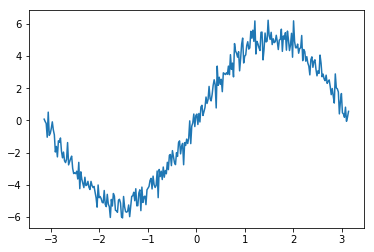

In [4]:
import matplotlib.pylab as plt


def sine_generator(N,L):
    X = np.zeros((N,L))
    Y = np.zeros((N,L))
    x = np.linspace(-np.pi, np.pi, L)
    amplitude = np.random.randn(N,1) * np.ones((N,L))
    Y = 10*np.sin(x)*amplitude
    X = Y + 0.5*np.random.randn(N,L)
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    return X, Y


# testing the generator
x = np.linspace(-np.pi, np.pi, L)
N = 1000
L=300
X, Y = sine_generator(N,L)

plt.plot(x,np.array(X[120,:]))
plt.show()


# Part 1: Vanilla RNN

Equations of a forward pass in a simple RNN network looks like this:

$s_{t}=f(Ux_{t}+b_{U}+Ws_{t-1}+b_{W})$

$o_{t}=f'(Vs_{t}+b_{V})$

Where:

$s_{t}$: Hidden state of RNN at time step t.

$x_{t}$: Input at time step t.

$U$: Learnable weight matrix for connections between the hidden state and input.

$W$: Learnable weight matrix for connections between the hidden states.

$V$: Learnable weight matrix for connections between the hidden state and output.

$o_{t}$: Output at time step t.

$f$ and $f'$: Nonlineartiy functions such as tanh, ReLU, & Softmax

$b_{U}$, $b_{W}$, and $b_{V}$: Bias terms

We talked what the bias term does in the class. In practice, bias terms are not held separately. Using the bias trick, we can store $W$ and bias term of a linear model $y=Wx+b$ in a single matrix. 
![The bias trick](../media/wb.jpg)
Using the bias trick, the equations of RNN are reduce to the following:

$s_{t}=f(Ux_{t}+Ws_{t-1})$

$o_{t}=f'(Vs_{t})$

PyTorch's $nn$ module has a function for a linear models such as $y=Wx+b$. Set $f$ and $f'$ to to *tanh*.

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.NonlinearFunc = nn.Tanh()
    
    def forward(self, input, hidden):
        hidden = self.input2hidden(input) + self.hidden2hidden(hidden)
        output = self.NonlinearFunc(self.hidden2output(hidden))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    
    
#params = list(rnn.parameters())
#print(len(params))
#print(params[0].size())


In [16]:
def predictor(output):
    return (output>0.5).double()    

rnn = RNN(input_size=1, hidden_size=100, output_size=1)
number_of_epochs = 10000
L = 20
N = 10
input, target = parity_generator(N,L)
print(input.size())
#target = target.view(-1)
#targer = target.float()
for epochs in range(number_of_epochs):

    criterion = nn.MSELoss()

    learning_rate = 0.001

    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    hidden = rnn.init_hidden()
    
    OUT = torch.tensor(np.zeros(L))
#    for i in range (int(L/2)):
#        rnn.zero_grad()
#        for j in range (2):
#            output, hidden = rnn(input[0,2*i+j].unsqueeze(0), hidden)
#            OUT[2*i+j] = output
#        loss = criterion(OUT[2*i:2*i+1].double().squeeze(), target[0,i:i+1])
#        loss.backward(retain_graph=True)
#        optimizer.step()
    rnn.zero_grad()
    for j in range (L):
        output, hidden = rnn(input[0,j].unsqueeze(0), hidden)
        OUT[j] = output
    loss = criterion(OUT.double(), target[0,:])
    loss.backward()
    optimizer.step()
print(loss)
OUTPUT = predictor(OUT)
E = abs(OUTPUT-target[0,:])
print(OUT)
print(target[0,:])
print(E)
true_percentage = 100*(1-sum(E)/L)
print(true_percentage)

        #return output, loss.data[0]

torch.Size([10, 20])
tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor([ 0.9575, -0.0027,  0.9686,  0.0247,  0.9853,  0.9157,  0.9693,  0.9707,
         0.0223,  0.9242, -0.0178,  0.0310, -0.0018, -0.0360,  0.0183,  0.0144,
         0.9222,  0.0065,  0.9192,  0.9576],
       dtype=torch.float64, grad_fn=<CopySlices>)
tensor([1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1.], dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)
tensor(100., dtype=torch.float64)


In [767]:
number_of_epochs = 1000
L = 20
input = Variable(torch.randint(0,2,(L,)))
target = np.zeros(L)
for i in range (input.size()[0]):
    target[i] = torch.sum(input[:i+1])%2
target = torch.from_numpy(target, )
target = target.view(-1)
targer = target.float()

hidden = rnn.init_hidden()
O = torch.tensor(np.zeros(L))
for i in range (L):
    #def train(category_tensor, line_tensor):
    rnn.zero_grad()
    #print(hidden)
    #for i in range(input.size()[0]):
    output, hidden = rnn(input[i].unsqueeze(0), hidden)
    O[i] = output


print(loss)
OUTPUT = predictor(O)
E = abs(OUTPUT-target)
print(OUTPUT)
print(1-sum(E)/L)
#print((((predictor(O)).float()-(target==1).float)))
#print(.sum().float()/L)

        #return output, loss.data[0]

tensor(0.0082, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0.], dtype=torch.float64)
tensor(0.7000, dtype=torch.float64)
